In [40]:
from cassandra.cluster import Cluster
import station_pb2_grpc
import station_pb2
import pandas as pd
import sys
import os
import subprocess
import grpc
from datetime import date

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import corr
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

Part 1

In [41]:
try:
    cluster = Cluster(['p6_db_2', 'p6_db_1', 'p6_db_3'])
    session = cluster.connect()
except Exception as e:
    print(e)

In [42]:
spark = (SparkSession.builder
         .appName("txt-reader")
         .config("spark.driver.allowMultipleContexts", "true")
         .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.2.0")
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

In [43]:
session.execute(" DROP KEYSPACE IF EXISTS weather;") # Ensure to drop the keyspace

# Create keyspace
session.execute("""CREATE KEYSPACE weather
  WITH REPLICATION = { 
   'class' : 'SimpleStrategy', 
   'replication_factor' : 3 
  };""")

# Create type
session.execute(""" CREATE type weather.station_record (
    tmin int,
    tmax int                
);""")

# Create table
session.execute(""" CREATE TABLE weather.stations (
    id text,
    name text STATIC,
    date date,
    record FROZEN<weather.station_record>,
    PRIMARY KEY (id, date)              
) WITH CLUSTERING ORDER BY (date ASC); """)

In [4]:
print(session.execute("describe keyspace weather").one().create_statement)
print(session.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;
CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record frozen<station_record>,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair = 'BLOC

In [44]:
if not os.path.exists("ghcnd-stations.txt"):
    ! wget https://pages.cs.wisc.edu/~harter/cs544/data/ghcnd-stations.txt

In [45]:
df = spark.read.text("ghcnd-stations.txt").toPandas()
df.head()

,value
0,ACW00011604 17.1167 -61.7833 10.1 ST JO...
1,ACW00011647 17.1333 -61.7833 19.2 ST JO...
2,AE000041196 25.3330 55.5170 34.0 SHARJ...
3,AEM00041194 25.2550 55.3640 10.4 DUBAI...
4,AEM00041217 24.4330 54.6510 26.8 ABU D...


In [46]:
col_ranges = {
    "ID" : [1, 11],
    "LATITUDE" : [13, 20],
    "LONGITUDE" : [22, 30],
    "ELEVATION" : [32, 37],
    "STATE" : [39, 40],
    "NAME" : [42, 71],
    "GSN FLAG" : [73, 75],
    "HCN/CRN FLAG" : [77, 79],
    "WMO ID" : [81, 85]
}

for col_name in col_ranges:
    range_vals = col_ranges[col_name]
    start_val, end_val = range_vals[0], range_vals[1]
    df[col_name] = df["value"].str[start_val - 1 : end_val]
    df[col_name] = df[col_name].str.strip()

wisconsin_data = df[df["STATE"] == "WI"]
print("Number of data points is", len(wisconsin_data.index))
wisconsin_data.head()

Number of data points is 1313


,value,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
93901,US1WIAD0002 43.9544 -89.8096 294.4 WI ADAMS...,US1WIAD0002,43.9544,-89.8096,294.4,WI,ADAMS 0.4 E,,,
93902,US1WIAD0005 44.2053 -89.8480 305.7 WI NEKOO...,US1WIAD0005,44.2053,-89.8480,305.7,WI,NEKOOSA 8.0 SSE,,,
93903,US1WIAD0006 43.8858 -89.7259 307.8 WI GRAND...,US1WIAD0006,43.8858,-89.7259,307.8,WI,GRAND MARSH 1.0 W,,,
93904,US1WIAD0008 43.8611 -89.7163 310.0 WI GRAND...,US1WIAD0008,43.8611,-89.7163,310.0,WI,GRAND MARSH 1.9 SSW,,,
93905,US1WIAD0010 43.7864 -89.6417 293.8 WI OXFOR...,US1WIAD0010,43.7864,-89.6417,293.8,WI,OXFORD 4.0 W,,,


In [47]:
query = "INSERT INTO weather.stations(id, name) VALUES (?, ?)"
prepared = session.prepare(query)
for index, row in df.iterrows():
    session.execute(prepared, (row["ID"], row["NAME"]) )

# Verify that the rows were inserted properly
rows = session.execute("SELECT id, name FROM weather.stations LIMIT 5")
print(rows[0])

Row(id='US1AZPM0036', name='TUCSON 3.9 NW')


/tmp/ipykernel_341/4276896248.py:8: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  print(rows[0])


In [49]:
result = subprocess.check_output(["nodetool", "ring"]).decode(sys.stdout.encoding)
print(result)


Datacenter: datacenter1
Address          Rack        Status State   Load            Owns                Token                                       
                                                                                9042877249209554468                         
172.27.0.2       rack1       Up     Normal  5.4 MiB         100.00%             -8715111515286740160                        
172.27.0.4       rack1       Up     Normal  5.26 MiB        100.00%             -7932906987615511327                        
172.27.0.3       rack1       Up     Normal  5.12 MiB        100.00%             -7813862271986098509                        
172.27.0.2       rack1       Up     Normal  5.4 MiB         100.00%             -7643610898946707347                        
172.27.0.2       rack1       Up     Normal  5.4 MiB         100.00%             -6625759494204280331                        
172.27.0.4       rack1       Up     Normal  5.26 MiB        100.00%             -6313883691918468029

In [51]:
# Get the row token
row = session.execute("SELECT token(id) FROM weather.stations WHERE id = %s", ("USC00470273",))
row_token = row.one()[0]

# Get all the vnode tokens
result = subprocess.check_output(["nodetool", "ring"]).decode(sys.stdout.encoding)
lines = result.splitlines()[3 : ]
token_idx = lines.pop(0).index("Token")
lines.pop(0)
tokens = [line[token_idx : ].strip() for line in lines]

# Get the v node token
vnode_token = None
if row_token <= int(tokens[0]):
    vnode_token = tokens[0]
else:
    for i in range(0, len(tokens) - 1):
        # Make sure the tokens are valid
        if len(tokens[i]) == 0 or len(tokens[i + 1]) == 0:
            continue
        
        # Check if the row is in this range
        if row_token >= int(tokens[i]) and row_token <= int(tokens[i + 1]):
            vnode_token = tokens[i + 1]
            break

In [52]:
print("row token:", row_token)
print("vnode token:", vnode_token)

row token: -9014250178872933741
vnode token: -8715111515286740160


In [54]:
spark.stop()

Part 2

In [55]:
if not os.path.exists("wi-stations.zip"):
    !wget https://pages.cs.wisc.edu/~harter/cs544/data/wi-stations.zip
    !unzip wi-stations.zip

In [66]:
PORT_TO_USE = 5440
SERVER_ADDRESS = f"127.0.0.1:{PORT_TO_USE}"

channel = grpc.insecure_channel(SERVER_ADDRESS)
stub = station_pb2_grpc.StationStub(channel)

23/09/01 17:51:04 WARN ChannelPool: [s1|/172.27.0.3:9042]  Error while opening new channel (ConnectionInitException: [s1|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=28ffa618-bd2b-48c5-9d20-653f261e26b1, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693588388533}): failed to send request (java.nio.channels.NotYetConnectedException))
23/09/01 17:51:05 WARN ChannelPool: [s0|p6_db_2/172.27.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=daedec1a-d180-4e35-bd75-e0e47f04aafe, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693588388533}): failed to send request (java.nio.channels.NotYetConnectedException))


In [57]:
def simulate_sensor(station):
    col_names = ["station_id", "date", "type", "value", "Unknown#1", "Unknown#2", "Unknown#3", "Unknown#4"]
    df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)

    record_by_date = {}
    for index, row in df.iterrows():
        # Make sure they are 2022 records
        record_date = str(row["date"]).strip()

        if record_date[ : 4] != "2022":
            continue
        
        # Make sure they are temperature records
        if row["type"] != "TMAX" and row["type"] != "TMIN":
            continue
        
        date_val = date(int(record_date[ : 4]), int(record_date[4 : 6]), int(record_date[6 : ]))
        if date_val not in record_by_date:
            record_by_date[date_val] = []
        record_by_date[date_val].append(int(row["value"]))
    
    for curr_date in record_by_date:
        date_temps = record_by_date[curr_date]
        response = stub.RecordTemps(station_pb2.RecordTempsRequest(station = station, date = str(curr_date), tmin = min(date_temps), tmax = max(date_temps)))

In [58]:
for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")

/tmp/ipykernel_341/2591731489.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)


max temp for USW00014837 is 356
max temp for USR0000WDDG is 344


/tmp/ipykernel_341/2591731489.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)


max temp for USW00014898 is 356


/tmp/ipykernel_341/2591731489.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)


max temp for USW00014839 is 378


In [ ]:
Part 3

In [59]:
spark = (SparkSession.builder
         .appName("cassandra-connector")
         .config("spark.driver.allowMultipleContexts", "true")
         .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.2.0")
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .config("spark.cassandra.connection.host", "p6_db_3,p6_db_2,p6_db_1")  # Cassandra nodes
         .config("spark.cassandra.connection.port", "9042")  # Cassandra port
         .getOrCreate())

In [60]:
# Load all the data
cassandra_df = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="stations", keyspace="weather") \
    .load()

# Create a temp view of the 2022 data and cache it
only_22_df = cassandra_df.filter(cassandra_df["date"].like("%2022%"))
only_22_view = only_22_df.createOrReplaceTempView("weather2022")
spark.table("weather2022").cache()
spark.sql("show tables").show()

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |weather2022|       true|
+---------+-----------+-----------+



In [61]:
# Register the UDF
def cel_to_far_converter(temp):
    return float((temp * 0.1) * 9.0/5.0 + 32.0)

spark.udf.register("cel_to_far", cel_to_far_converter)

<function __main__.cel_to_far_converter(temp)>

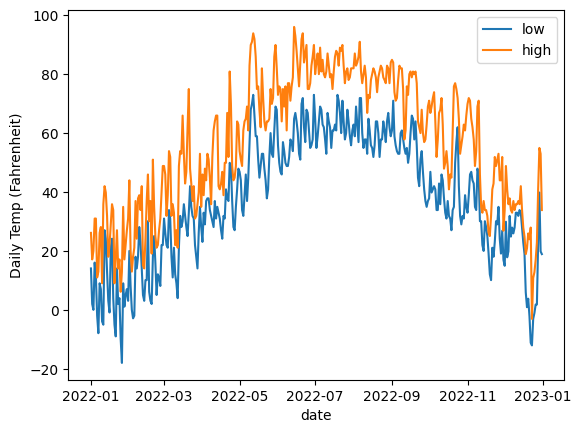

In [62]:
data = spark.sql("""
SELECT id, date, cel_to_far(record.tmin) as min_temp, cel_to_far(record.tmax) as max_temp
FROM weather2022
WHERE id = "USW00014837"
""").toPandas()

data["min_temp"]= data['min_temp'].astype(float) #for plotting
data['max_temp'] = data['max_temp'].astype(float)

fig = data.plot.line(x = "date", y = ["min_temp", "max_temp"], ylabel = "Daily Temp (Fahrenheit)")
fig.legend(["low", "high"])

In [63]:
station1 = spark.sql("""
SELECT id, cel_to_far(record.tmax) as temp_max
FROM weather2022
WHERE id = "USW00014837" 
""").toPandas()

station2 = spark.sql("""
SELECT id, cel_to_far(record.tmax) as temp_max
FROM weather2022
WHERE id = "USW00014839" 
""").toPandas()

combined_maxes = spark.createDataFrame(zip(station1["temp_max"], station2["temp_max"]), ["station1", "station2"])
coor_row = combined_maxes.agg(corr("station1", "station2").alias("corr")).collect()
coor_val = list(coor_row[0])[0]
print("Correlation is", coor_val)

Correlation is 0.9786907979650679


Part 4

In [67]:
stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))

tmax: -1
error: "Couldn\'t find max value for station USW00014837"

23/09/01 17:51:21 WARN ChannelPool: [s1|/172.27.0.3:9042]  Error while opening new channel (ConnectionInitException: [s1|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=28ffa618-bd2b-48c5-9d20-653f261e26b1, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693588388533}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))
23/09/01 17:51:21 WARN ChannelPool: [s0|p6_db_2/172.27.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=daedec1a-d180-4e35-bd75-e0e47f04aafe, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693588388533}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChanne

In [68]:
simulate_sensor("USC00477115")

In [69]:
count  = spark.sql("""
SELECT COUNT(record) AS count
FROM weather2022
""").collect()

print("Pre refersh count", list(count[0])[0])

Pre refersh count 1460


In [70]:
spark.sql("REFRESH TABLE weather2022")
count  = spark.sql("""
SELECT COUNT(record) AS count
FROM weather2022
""").collect()

print("Post refersh count", list(count[0])[0])

23/09/01 17:51:31 ERROR CassandraConnectorConf: Unknown host 'p6_db_2'
java.net.UnknownHostException: p6_db_2: Temporary failure in name resolution
	at java.net.Inet4AddressImpl.lookupAllHostAddr(Native Method)
	at java.net.InetAddress$2.lookupAllHostAddr(InetAddress.java:867)
	at java.net.InetAddress.getAddressesFromNameService(InetAddress.java:1302)
	at java.net.InetAddress$NameServiceAddresses.get(InetAddress.java:815)
	at java.net.InetAddress.getAllByName0(InetAddress.java:1291)
	at java.net.InetAddress.getAllByName(InetAddress.java:1144)
	at java.net.InetAddress.getAllByName(InetAddress.java:1065)
	at java.net.InetAddress.getByName(InetAddress.java:1015)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.maybeResolveHostAndPort(CassandraConnectorConf.scala:346)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.$anonfun$getIpBasedContactInfoFromSparkConf$1(CassandraConnectorConf.scala:379)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.

Post refersh count 1825


In [72]:
spark.stop()
session.shutdown()
cluster.shutdown()
